<a href="https://colab.research.google.com/github/Urara29/Generate-Music-from-Image/blob/main/music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#カレントディレクトリに移動
%cd "/content/drive/My Drive/sotsuron/"

/content/drive/My Drive/sotsuron


In [ ]:
#!/opt/conda/bin/python3.7 -m pip install --upgrade pip
#!pip install tensorflow-addons
#!pip install --upgrade --ignore-installed tensorflow
#!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.0 MB/s eta 0:00:00


In [6]:
import librosa

import numpy as np
import pandas as pd
import os

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from keras.models import Sequential

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

import glob
import imageio
import time
import IPython.display as ipd

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [7]:
seed=123
tf.compat.v1.set_random_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [8]:
BATCH_SIZE = 128
epochs = 120
latent_dim = 10
num_examples_to_generate = 1

BASE_PATH = './AE_music'

In [9]:
def DatasetLoader(class_):
    music_list = np.array(sorted(os.listdir(BASE_PATH+'/'+class_)))
    train_music_1 = list(music_list[:294])
    train_music_2 = list(music_list[295:])
    train_music_3 = list(music_list[:])
    TrackSet_1 = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_music_1]
    TrackSet_2 = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_music_2]

    return TrackSet_1, TrackSet_2

In [10]:
def load(file_):
    data_, sampling_rate = librosa.load(file_,sr=16000, offset=0.0, duration=7.0)
    data_ = data_.reshape(1,112000)
    return data_
map_data = lambda filename: tf.compat.v1.py_func(load, [filename], [tf.float32])

In [11]:
TrackSet_1, TrackSet_2 = DatasetLoader('e1_to_e4_new')

In [12]:
sample = TrackSet_1[0]
sample_, sampling_rate = librosa.load(sample,sr=16000, offset=0.0, duration=7.0)
ipd.Audio(sample_,rate=16000)

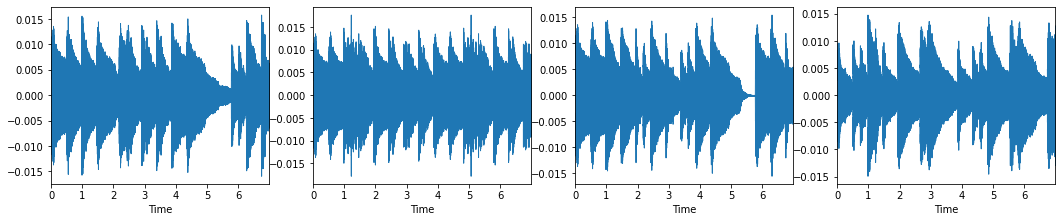

In [13]:
import librosa.display
plt.figure(figsize=(18,15))
for i in range(4):
    plt.subplot(4, 4, i + 1)
    j = load(TrackSet_1[i])
    librosa.display.waveplot(j[0], sr=16000)

In [14]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_1))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_2))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)
train_dataset2 = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_1))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    #.shuffle(3)
    .batch(BATCH_SIZE)
)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [15]:
class Resnet1DBlock(tf.keras.Model):
    def __init__(self, kernel_size, filters,type='encode'):
        super(Resnet1DBlock, self).__init__()
    
        if type=='encode':
            self.conv1a = layers.Conv1D(filters, kernel_size, 2,padding="same")
            self.conv1b = layers.Conv1D(filters, kernel_size, 1,padding="same")
            self.norm1a = tfa.layers.InstanceNormalization()
            self.norm1b = tfa.layers.InstanceNormalization()
        if type=='decode':
            self.conv1a = layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.conv1b = layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.norm1a = tf.keras.layers.BatchNormalization()
            self.norm1b = tf.keras.layers.BatchNormalization()
        else:
            return None

    def call(self, input_tensor):
        x = tf.nn.relu(input_tensor)
        x = self.conv1a(x)
        x = self.norm1a(x)
        x = layers.LeakyReLU(0.4)(x)

        x = self.conv1b(x)
        x = self.norm1b(x)
        x = layers.LeakyReLU(0.4)(x)

        x += input_tensor
        return tf.nn.relu(x)

In [16]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(1,112000)),
                layers.Conv1D(64,1,2),
                Resnet1DBlock(64,1),
                layers.Conv1D(128,1,2),
                Resnet1DBlock(128,1),
                layers.Conv1D(128,1,2),
                Resnet1DBlock(128,1),
                layers.Conv1D(256,1,2),
                Resnet1DBlock(256,1),
                # No activation
                layers.Flatten(),
                layers.Dense(latent_dim+latent_dim)

            ]
        )
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                layers.Reshape(target_shape=(1,latent_dim)),
                Resnet1DBlock(512,1,'decode'),
                layers.Conv1DTranspose(512,1,1),
                Resnet1DBlock(256,1,'decode'),
                layers.Conv1DTranspose(256,1,1),
                Resnet1DBlock(128,1,'decode'),
                layers.Conv1DTranspose(128,1,1),
                Resnet1DBlock(64,1,'decode'),
                layers.Conv1DTranspose(64,1,1),
                # No activation
                layers.Conv1DTranspose(112000,1,1),
            ]
        )
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(200, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    @tf.function
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    @tf.function
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    @tf.function
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [17]:
optimizer = tf.keras.optimizers.Adam(0.0003,beta_1=0.9, beta_2=0.999,epsilon=1e-08)

In [18]:
@tf.function
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
         -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
          axis=raxis)

In [19]:
@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [24]:
@tf.function
def train_step(model, x, optimizer):
    
    """Executes one training step and returns the loss.

       This function computes the loss and gradients, and uses the latter to
       update the model's parameters.
     """
    with tf.GradientTape() as tape:
            mean, logvar = model.encode(x)
            z = model.reparameterize(mean, logvar)
            x_logit = model.decode(z)
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
            logpz = log_normal_pdf(z, 0., 0.)
            logqz_x = log_normal_pdf(z, mean, logvar)
            loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x)
            reconstruction_loss = tf.reduce_mean(
                     tf.keras.losses.binary_crossentropy(x, x_logit)
                 )
            total_loss = reconstruction_loss+ loss_KL
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [20]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [21]:
import librosa.display

def generate_and_save_images(model, epoch, test_sample, save):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(60, 60))

    for i in range(predictions.shape[0]):
        plt.subplot(10, 8, i + 1)
        wave = np.asarray(predictions[i])
        librosa.display.waveplot(wave[0], sr=16000)

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('{}_{:04d}.png'.format(save, epoch))
    plt.savefig('{}_{:04d}.png'.format(save, epoch))
    plt.show()

In [22]:
# Pick a sample of the test set for generating output images
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0]

In [ ]:
generate_and_save_images(model, 0, test_sample, 'e1_to_e4_new')
def train(train_dataset, test_dataset, model, save):
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        for train_x in train_dataset:
            train_x = np.asarray(train_x)[0]
            train_step(model, train_x, optimizer)
        end_time = time.time()

        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            test_x = np.asarray(test_x)[0]
            loss(compute_loss(model, test_x))
        display.clear_output(wait=False)
        elbo = -loss.result()
        print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch, 
                                                                                       elbo, 
                                                                                       end_time - start_time
                                                                                      ))
        generate_and_save_images(model,
                                 epoch, 
                                 test_sample,
                                 save)
train(train_dataset, test_dataset, model, 'e1_to_e4_new')

Epoch: 56, Test set ELBO: 885923328.0, time elapse for current epoch: 89.36638641357422


In [ ]:
anim_file_1 = 'e1_to_e4_new_cvae.gif'

with imageio.get_writer(anim_file_1, mode='I') as writer:
    filenames = glob.glob('e1_to_e4_new*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file_1)

In [ ]:
def inference(test_dataset, model):  
    save_music = []
    for test in test_dataset:
        mean, logvar = model.encode(test)
        z = model.reparameterize(mean, logvar)
        predictions = model.sample(z)
        for pred in predictions:
            wave = np.asarray(pred)
            save_music.append(wave)
    return save_music

saved_musics = inference(test_dataset, model)

In [ ]:
music1=saved_musics[0][0]
ipd.Audio(music1,rate=16000)


In [ ]:
music2=saved_musics[1][0]
ipd.Audio(music2,rate=16000)

In [ ]:
music3=saved_musics[2][0]
ipd.Audio(music3,rate=16000)

In [ ]:
music4=saved_musics[3][0]
ipd.Audio(music4,rate=16000)

In [ ]:
music5=saved_musics[4][0]
ipd.Audio(music5,rate=16000)

In [ ]:
music6=saved_musics[5][0]
ipd.Audio(music6,rate=16000)

In [ ]:
from keras.models import model_from_json
# モデルの読み込み
SAVE_DATA_DIR_PATH = "/content/drive/My Drive/sotsuron/"
model = model_from_json(open(SAVE_DATA_DIR_PATH + "model.json", 'r').read())

# 重みの読み込み
model.load_weights('weight.hdf5')

JSONDecodeError: ignored

In [ ]:
def inference(train_dataset2, model):  
    mean_list = []
    for test in train_dataset2:
        mean, logvar = model.encode(test)
        mean_list.append(mean)
    return mean_list

means = inference(train_dataset2, model)

NameError: ignored

In [ ]:
print(means)

[<tf.Tensor: shape=(64, 10), dtype=float32, numpy=
array([[-13.959892 , -13.060017 , -12.971871 , -13.331134 , -13.9932   ,
        -14.106595 , -13.264866 , -13.546434 , -13.252478 , -15.943561 ],
       [-18.592407 , -17.72318  , -17.332418 , -17.907612 , -18.753412 ,
        -18.840164 , -17.742142 , -18.08598  , -17.821493 , -21.26971  ],
       [ -4.000926 ,  -3.7715442,  -3.7231576,  -3.8647022,  -4.0127907,
         -4.0585732,  -3.7751925,  -3.9047928,  -3.7712069,  -4.5577254],
       [-23.818512 , -22.670673 , -22.230333 , -23.035034 , -23.99731  ,
        -24.223978 , -22.69323  , -23.180542 , -22.86776  , -27.05893  ],
       [-12.914674 , -12.156273 , -12.041333 , -12.444017 , -13.009678 ,
        -13.088249 , -12.318196 , -12.553422 , -12.370973 , -14.716099 ],
       [-57.373028 , -54.880608 , -54.011547 , -55.67796  , -56.65432  ,
        -58.047962 , -54.265602 , -55.586708 , -54.71374  , -63.673267 ],
       [-33.48633  , -32.014893 , -31.358856 , -32.343544 , -32.996

In [ ]:
# モデルの保存
open('model.json',"w").write(model.to_json())

# 学習済みの重みを保存
model.save_weights('weight_epoch100.hdf5')